#  Solving the Inviscid Burgers equation

Here we solve the inviscid Burgers Equation

$$\partial_t u(t,x) = u(t,x) \partial_x u(t,x),$$

with the initial conditions

$$u(0,x) = f(x) = \begin{cases}1 && \text{if }x < 0\\1-x && \text{if }0\leq x \leq 1\\0 && \text{if }1< x \\\end{cases}$$

We impose the initial conditions by weak enforcement.

<br>

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import display

In [10]:
def gradients(outputs, inputs, order = 1):
    if order == 1:
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    elif order > 1:
        return gradients(gradients(outputs, inputs, 1), inputs, order - 1) # Recursively take gradients
    else:
        return outputs

def generate_2Dgrid(minimum1, maximum1, minimum2, maximum2, N):
    grid1 = np.linspace(minimum1, maximum1, N, dtype = np.float32)
    grid2 = np.linspace(minimum2, maximum2, N, dtype = np.float32)
    x0, y0 = np.meshgrid(grid1, grid2)
    x = torch.tensor(x0.reshape(N**2), requires_grad = True)
    y = torch.tensor(y0.reshape(N**2), requires_grad = True)
    return x, y

def plot_form(x, y, z, N):
    return map(lambda t: t.reshape(N,N).cpu().detach().numpy(), (x, y, z))

In [8]:
# The ODE solution will be modelled as a NN with 1 hidden layer of 40 nodes 
class InviscidBurgers(nn.Module):
    def __init__(self):
        super(InviscidBurgers, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 1),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean = 0, std = 0.1)  #initialize with normal weights and constant biases
                nn.init.constant_(m.bias, val = 0.0)
                
    def forward(self, t, x):
        tx = torch.stack((t,x), 1)
        #bdry = (abs(x) - 1).reshape(len(x), 1)
        return self.net(tx) #* bdry

# The loss function that will be used to train the NN will be constructed
# out of the DE
def g(x):
    if x < -1:
        return 1
    elif x < 1:
        return (1-x)/2
    else:
        return 0




class InviscidBurgersLoss(nn.Module):
    def __init__(self, approx_sol):
        super(InviscidBurgersLoss, self).__init__()
        self.approx_sol = approx_sol
        
    def forward(self, t, x):

       # global test1, test2, test3, test4
      
        u   =  self.approx_sol(t, x).squeeze()
        u_t = gradients(u, t)
        u_x = gradients(u, x)

        eq = u_t + u* u_x

        # loss function associated with satisfying DE        
        eq_loss = (eq)**2



        #define the initial values of t,x
        tinitial=torch.zeros(30)
        xinitial=torch.as_tensor([x[30*i] for i in range(30)])

        #pde(torch.zeros(30),xvalues)-torch.as_tensor(list(map(g, xvalues)))

        ic = torch.flatten(self.approx_sol(tinitial,xinitial) )#self.approx_sol(torch.zeros(x.detach().numpy().size), x)
        

        #loss function that constrains Initial Conditions
        #ic_loss = map(lambda elem : (elem[0]-1)**2 if elem[1] < -1 else (elem[0] - (1-elem[1]))**2 if elem[1] < 1 else x[0]**2, zip(ic, x))
        ic_loss =(ic - torch.as_tensor(list(map(g, xinitial))))**2
        
       # test1=eq_loss
       ## test3=u_x
        #test2= ic_loss
        #test4=u*u_x

        return torch.sum(eq_loss)+2*30*torch.sum(ic_loss) #torch.mean(torch.cat((eq_loss, 2*ic_loss),dim=0)) #torch.mean(eq_loss.append() ) #

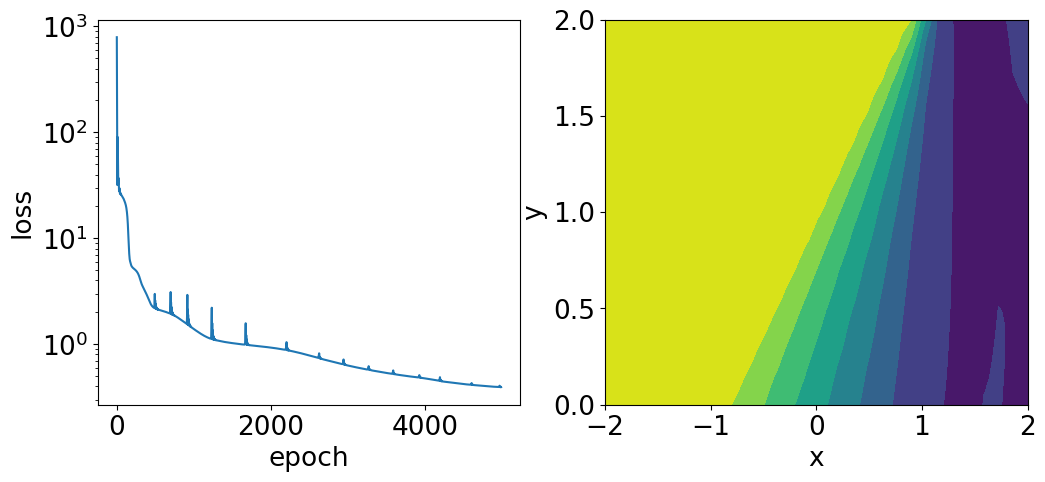

In [11]:
pde      = InviscidBurgers()
pde_loss = InviscidBurgersLoss(pde)
loss_hist = []

tgr, xgr = generate_2Dgrid(0, 2, -2, 2, 30)
optimizer = optim.Adam(pde.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(0.1)**(1/5000))

################## Training and Plotting ##################

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 5));
font = {'size'   : 19}
plt.rc('font', **font)

for it in range(5000):
    try:
        optimizer.zero_grad()

        loss = pde_loss(tgr, xgr)
        loss_hist.append(loss.cpu().detach().numpy())

        loss.backward()
        optimizer.step()
        scheduler.step()
    
        if  it %10 == 0:
            t_plot, x_plot, u_plot = plot_form(xgr, tgr, pde(tgr, xgr), 30)
            
            ax1.cla()
            ax1.set_xlabel('epoch')
            ax1.set_ylabel('loss')
            ax1.set_yscale('log')
            ax1.plot(loss_hist)
            
            ax2.cla()
            ax2.set_xlabel('x')
            ax2.set_ylabel('y')
            ax2.contourf(t_plot, x_plot, u_plot)
            
            display.display(plt.gcf())
            display.clear_output(wait=True)

    except KeyboardInterrupt:
        break